In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Input Data
T_amb = 27.0 # Ambient Temperature (in degrees celsius)
T_0 = 250.0 # Initial temperature (in degrees celsius)
k = 0.45 # Constant

In [3]:
#Define the neural network model
# create_model() -Function to return a dictionary representing a neural network model.
#The dictionary has keys as Layer NAmes and values as the corresponding Dense Layers
def create_model():
  model = {
      'dense1': tf.keras.layers.Dense(50, activation='tanh'),
      'dense2': tf.keras.layers.Dense(50, activation='tanh'),
      'dense3': tf.keras.layers.Dense(50, activation='tanh'),
      'output_layer': tf.keras.layers.Dense(1, dtype='float32')
  }
  return model

#call_model() - Function to define the forward pass of nn
#Takes as an input a dictionary model and an input tensor x

def call_model(model,t):
  t = model['dense1'](t)
  t = model['dense2'](t)
  t = model['dense3'](t)
  t = model['output_layer'](t)
  return t

#model = create_model()
#print(model)

In [4]:
#Define the differential equation using tf.GradientTape

def pde(t, model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(t)
    T_pred = call_model(model,t)
    T_t = tape.gradient(T_pred, t)
  del tape
  return T_t - k*(T_amb - T_pred)

In [5]:
#Define the loss function
def loss(model, t, t_ic, T_ic):
  f = pde(t, model)

  #Mean Squared Error (MSE) of boundary conditions
  loss_pde = tf.reduce_mean(tf.square(f))
  T_ic_pred = call_model(model, t_ic)

  #Compute MSE for boundary conditions
  loss_ic = tf.reduce_mean(tf.square(T_ic - T_ic_pred))

  return loss_pde + loss_ic

In [6]:
# Define the training step
@tf.function
def train_step(model, t, t_ic, T_ic, optimizer):
  with tf.GradientTape() as tape:
    loss_value = loss(model, t, t_ic, T_ic)
  grads = tape.gradient(loss_value, [layer.trainable_variables for layer in model.values()])
  # Flatten the list of trainable variables
  grads = [grad for sublist in grads for grad in sublist]
  variables = [var for layer in model.values() for var in layer.trainable_variables]
  optimizer.apply_gradients(zip(grads, variables))
  return loss_value

In [7]:
# Setting up the problem

#Generating Training Data

t_train = np.linspace(0, 10, 100).reshape(-1, 1)
t_train = tf.convert_to_tensor(t_train, dtype=tf.float32)

#Boundary data
t_ic = np.array([[0.0]], dtype = np.float32)
T_ic = np.array([[T_0]], dtype = np.float32)
t_ic = tf.convert_to_tensor(t_ic, dtype = tf.float32)
T_bc = tf.convert_to_tensor(T_ic, dtype= tf.float32)

#The PINN model
model = create_model()

#Define the optimizer with a alearning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-3, decay_steps = 500, decay_rate = 0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

#Train the model
epochs = 15000
for epoch in range(epochs):
  loss_value = train_step(model, t_train, t_ic, T_ic, optimizer)
  if epoch % 500 == 0:
    print(f"Epoch {epoch}: Loss = {loss_value.numpy()}")

Epoch 0: Loss = 62645.57421875
Epoch 500: Loss = 45694.76953125
Epoch 1000: Loss = 36851.27734375
Epoch 1500: Loss = 29999.826171875
Epoch 2000: Loss = 24635.865234375
Epoch 2500: Loss = 20436.53515625
Epoch 3000: Loss = 17165.86328125
Epoch 3500: Loss = 14642.7724609375
Epoch 4000: Loss = 12723.8671875
Epoch 4500: Loss = 11292.732421875
Epoch 5000: Loss = 5545.45703125
Epoch 5500: Loss = 3875.232177734375
Epoch 6000: Loss = 2680.159423828125
Epoch 6500: Loss = 1816.074462890625
Epoch 7000: Loss = 1199.5469970703125
Epoch 7500: Loss = 770.9618530273438
Epoch 8000: Loss = 471.2559509277344
Epoch 8500: Loss = 234.1285400390625
Epoch 9000: Loss = 110.10249328613281
Epoch 9500: Loss = 46.09785079956055
Epoch 10000: Loss = 16.457670211791992
Epoch 10500: Loss = 4.780233860015869
Epoch 11000: Loss = 1.076191782951355
Epoch 11500: Loss = 0.18655475974082947
Epoch 12000: Loss = 0.02103506401181221
Epoch 12500: Loss = 0.007297215051949024
Epoch 13000: Loss = 0.0015172493876889348
Epoch 13500: L

In [8]:
# Predit the solution

t_test = np.linspace(0, 10, 1000).reshape(-1, 1)
t_test = tf.convert_to_tensor(t_test, dtype=tf.float32)
T_pred = call_model(model, t_test).numpy()

# Analytical solution
T_true = T_amb + (T_0 - T_amb) * np.exp(-k * t_test)

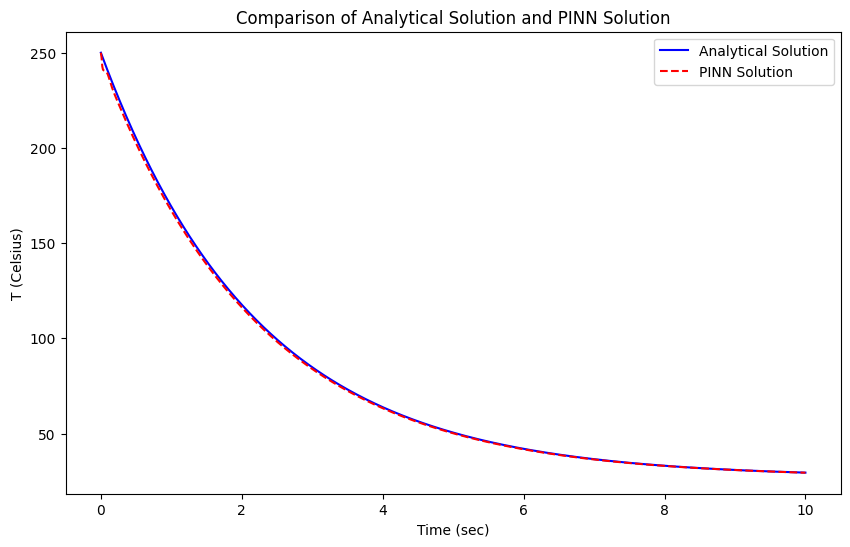

In [9]:
#Plot the results

plt.figure(figsize=(10,6))
plt.plot(t_test, T_true, 'b-', label = 'Analytical Solution')
plt.plot(t_test, T_pred, 'r--', label = 'PINN Solution')
plt.xlabel('Time (sec)')
plt.ylabel('T (Celsius)')
plt.legend()
plt.title('Comparison of Analytical Solution and PINN Solution')
plt.show()